In [49]:
from medvqa.utils.files import load_json_file
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

### MIMIC-CXR statistics

In [48]:
from medvqa.datasets.mimiccxr import MIMICCXR_CACHE_DIR, MIMICCXR_SPLIT_CSV_PATH
from medvqa.datasets.mimiccxr.mimiccxr_vqa_dataset_management import _MIMICCXR_STUDY_REGEX

In [39]:
df_split = pd.read_csv(MIMICCXR_SPLIT_CSV_PATH)

In [40]:
df_split

,dicom_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train
...,...,...,...,...
377105,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,57132437,19999733,train
377106,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,57132437,19999733,train
377107,58766883-376a15ce-3b323a28-6af950a0-16b793bd,55368167,19999987,train
377108,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,58621812,19999987,train


In [43]:
split_dict = {}
for sub_id, stud_id, dicom_id, split in zip(df_split['subject_id'],
                                            df_split['study_id'],
                                            df_split['dicom_id'],
                                            df_split['split']):
    key = (sub_id, stud_id)
    if key in split_dict:
        assert split_dict[key] == split
    else:
        split_dict[key] = split

In [4]:
qa_dataset = load_json_file(os.path.join(MIMICCXR_CACHE_DIR, 'qa_adapted_reports__20220629_050643.json'))

In [50]:
train_indices = []
test_indices = []
for i, r in enumerate(qa_dataset['reports']):
    _, subject_id, study_id = map(int, _MIMICCXR_STUDY_REGEX.findall(r['filepath'])[0])
    if split_dict[(subject_id, study_id)] == 'test':
        test_indices.append(i)
    else:
        train_indices.append(i)

In [51]:
len(train_indices), len(test_indices)

(224566, 3269)

#### Num questions per report

In [52]:
def question_statistics_per_report(qa_dataset, indices):
    reports = qa_dataset['reports']
    num_questions = [len(reports[i]['question_ids']) for i in indices]
    plt.hist(num_questions, bins=100)
    plt.show()
    print('average number of questions:', np.mean(num_questions))

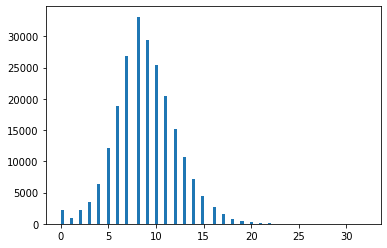

average number of questions: 8.908997800201277


In [53]:
question_statistics_per_report(qa_dataset, train_indices)

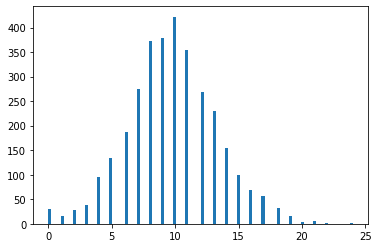

average number of questions: 9.737228510247782


In [54]:
question_statistics_per_report(qa_dataset, test_indices)

#### Num reports per question

In [85]:
def plot_num_reports_per_question(qa_dataset, indices, figsize=(8, 25)):
    n_q = len(qa_dataset['questions'])
    counts = [0] * n_q
    for i in indices:
        r = qa_dataset['reports'][i]
        for qid in r['question_ids']:
            counts[qid] += 1
    
    qids = list(range(n_q))
    qids.sort(key=lambda i : counts[i])
    
    sorted_counts = [counts[i] for i in qids]
    sorted_names = [f"{qa_dataset['questions'][i]} - {counts[i]} ({100 * counts[i] / len(indices):.2f})%)" for i in qids]
    
    plt.figure(figsize=figsize)
    plt.barh(list(range(n_q)), sorted_counts, tick_label=sorted_names)
    plt.show()

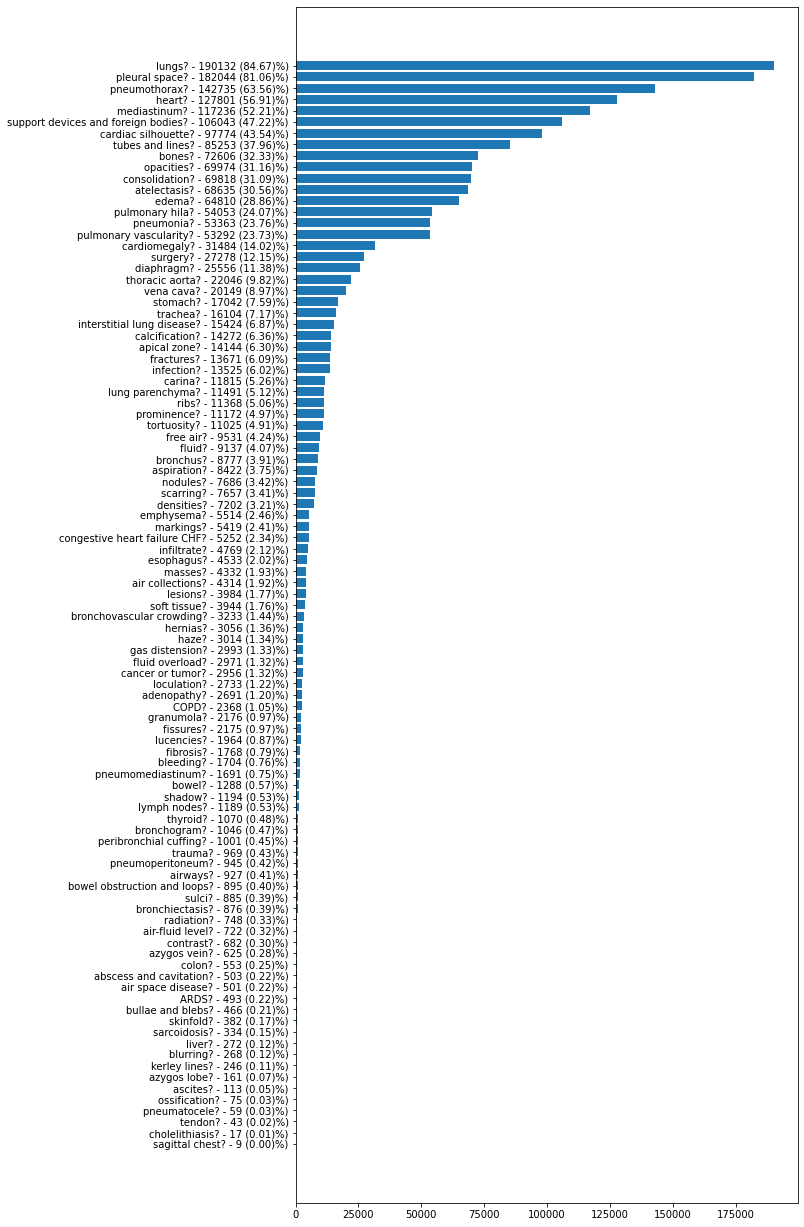

In [86]:
plot_num_reports_per_question(qa_dataset, train_indices, figsize=(9, 22))

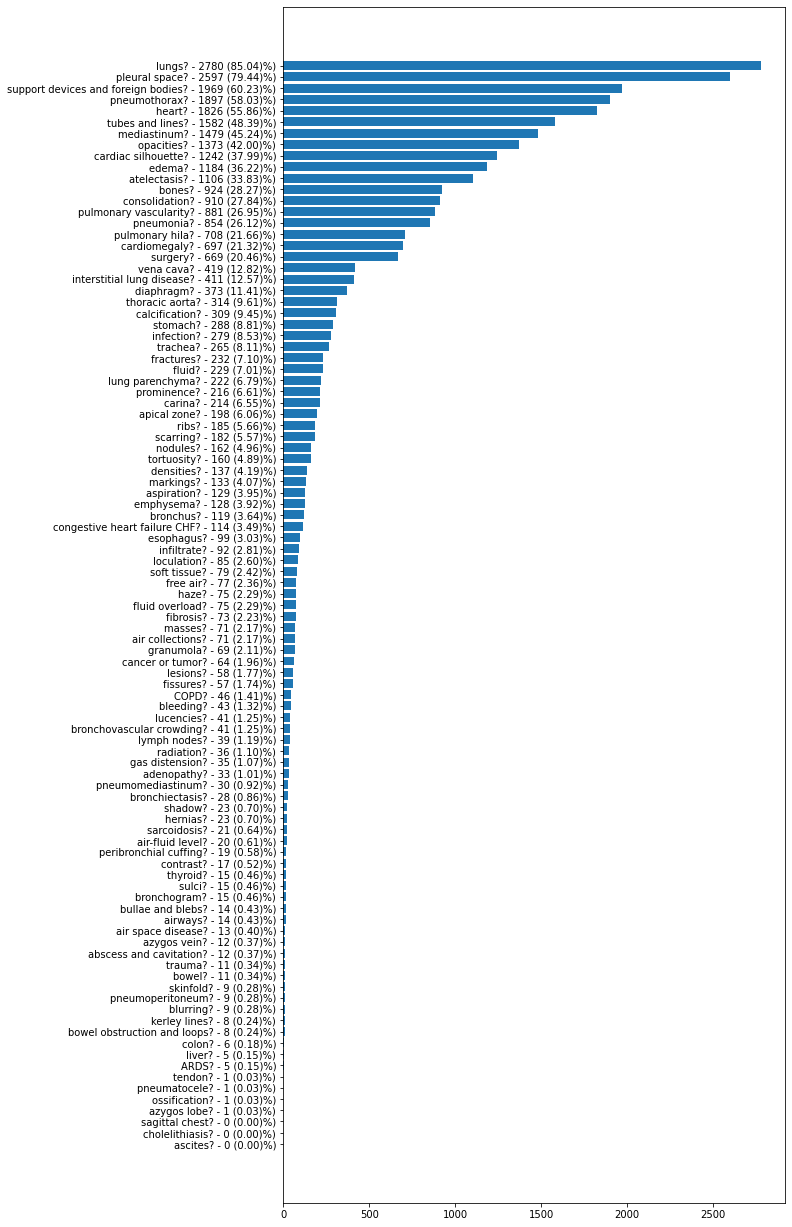

In [87]:
plot_num_reports_per_question(qa_dataset, test_indices, figsize=(9, 22))

### IU X-Ray statistics

In [59]:
from medvqa.datasets.iuxray import IUXRAY_CACHE_DIR

In [60]:
iuxray_qa_dataset = load_json_file(os.path.join(IUXRAY_CACHE_DIR, 'qa_adapted_reports__20220629_042239.json'))

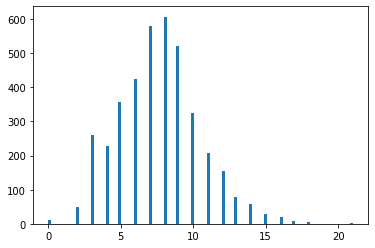

average number of questions: 7.632543926661573


In [61]:
question_statistics_per_report(iuxray_qa_dataset, list(range(len(iuxray_qa_dataset['reports']))))

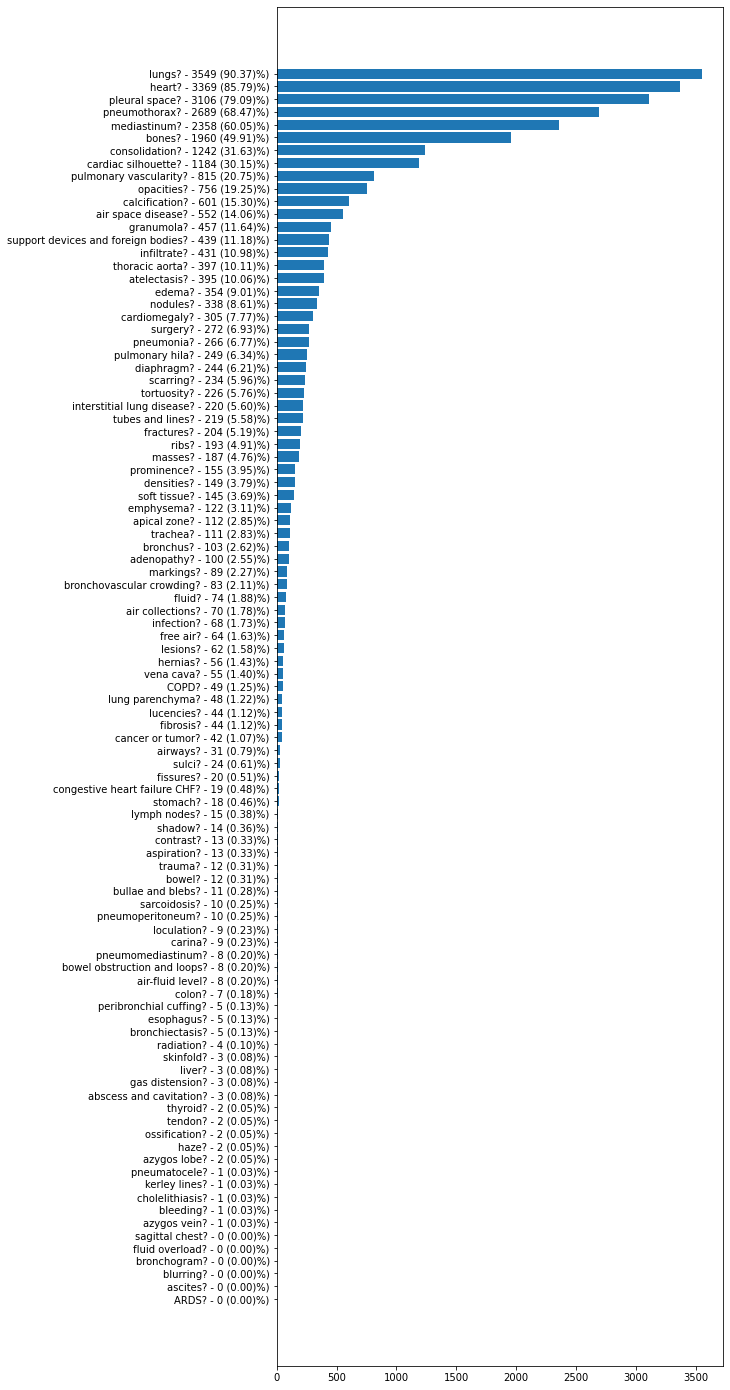

In [88]:
plot_num_reports_per_question(iuxray_qa_dataset, list(range(len(iuxray_qa_dataset['reports']))))

## Chexpert Labels

In [70]:
from medvqa.utils.files import load_pickle
from medvqa.utils.constants import CHEXPERT_LABELS

In [64]:
chexpert_labels = load_pickle(os.path.join(MIMICCXR_CACHE_DIR, 'chexpert_labels_per_report__20220629_055159.pkl'))

In [65]:
chexpert_labels(chexpert_labels)

227835

In [67]:
def chexpert_statistics_per_report(indices):
    num_labels = [chexpert_labels[i].sum() for i in indices]
    plt.hist(num_labels, bins=100)
    plt.show()
    print('average number of labels:', np.mean(num_labels))

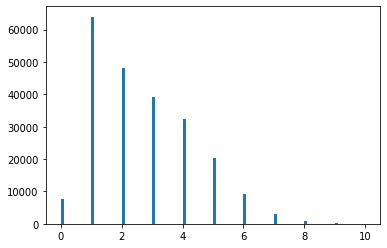

average number of labels: 2.6384091981867246


In [68]:
chexpert_statistics_per_report(train_indices)

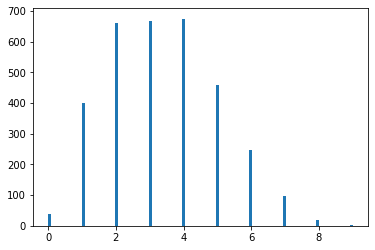

average number of labels: 3.3869684918935454


In [69]:
chexpert_statistics_per_report(test_indices)

In [81]:
def plot_num_reports_per_chexpert_label(indices, figsize=(8, 25)):
    n_q = len(CHEXPERT_LABELS)
    counts = [0] * n_q
    for i in indices:
        r = chexpert_labels[i]
        for i, x in enumerate(r):
            if x: counts[i] += 1
    
    qids = list(range(n_q))
    qids.sort(key=lambda i : counts[i])
    
    sorted_counts = [counts[i] for i in qids]
    sorted_names = [f"{CHEXPERT_LABELS[i]} - {counts[i]} ({100 * counts[i] / len(indices):.2f})%)" for i in qids]
    
    plt.figure(figsize=figsize)
    plt.barh(list(range(n_q)), sorted_counts, tick_label=sorted_names)
    plt.show()

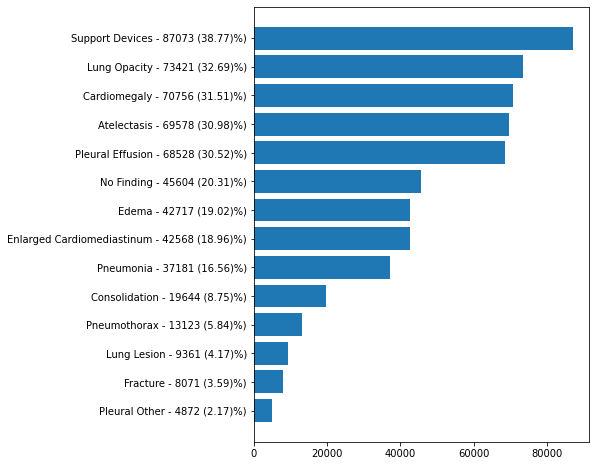

In [82]:
plot_num_reports_per_chexpert_label(train_indices, figsize=(6, 8))

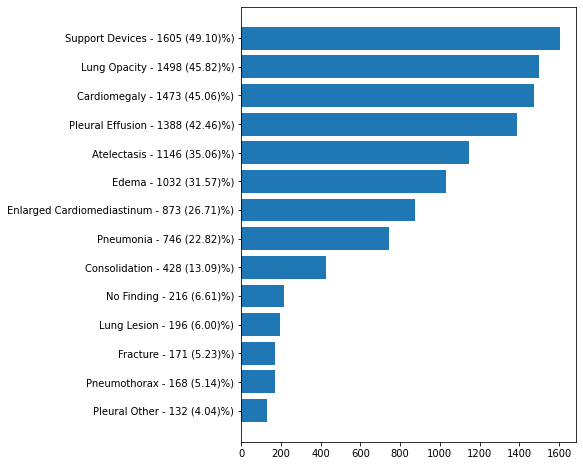

In [84]:
plot_num_reports_per_chexpert_label(test_indices, figsize=(6, 8))